# Neural & Behavioral Modeling - Week 12 (Exercises)
by 劉昱維 (r08227111@ntu.edu.tw)

In [137]:
%config IPCompleter.greedy=True 
%matplotlib inline
from matplotlib.pyplot import *
from IPython.display import *
import numpy as np
from pandas import DataFrame
import random


In [138]:
# Check GPU status:
import torch as t
print('PyTorch version:',t.__version__)
use_cuda=t.cuda.is_available()
if(use_cuda):
    for i in range(t.cuda.device_count()):
        print('Device ',i,':',t.cuda.get_device_name(i))
    print('Current: Device ',t.cuda.current_device())
    t.backends.cudnn.benchmark = True 
    device = t.device("cuda:0")
else:
    device = t.device("cpu")
    print('No GPU')

PyTorch version: 0.4.0
Device  0 : GeForce GTX 1080 Ti
Device  1 : GeForce GTX 1080 Ti
Device  2 : GeForce GTX 1080 Ti
Device  3 : GeForce GTX 1080 Ti
Current: Device  0


## 1 Fair Performance Evaluation (5 points)
We often compare and assess performances of different model architectures/parameters/hyperparameters. Note that the results are differnt even if you re-run exactly the same code block. This is primarily due to a non-fixed random number seed. Please:

(1) run the section 1.2 TEN times and report (a) min, (b) max, (c) mean, & (d) standard deviation of the TESTING accuracies. (3 points)

(2) try to fix the random number seeds in numpy & pytorch to see if you can obtain the same results every time in the section 1.2. (2 points)

### 1.0 CIFAR-10 dataset

In [139]:
# Load the dataset:
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
train_set = CIFAR10(root='.', train=True,download=True, transform=transforms.ToTensor())
train_data = t.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_set = CIFAR10(root='.', train=False,download=True, transform=transforms.ToTensor())
test_data = t.utils.data.DataLoader(train_set, batch_size=1000, shuffle=True)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### 1.1 The model

In [140]:
# Make the model:
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__() # = nn.Module.__init__(self)
        self.conv1 = nn.Conv2d(3, 6, 5) # in, out, kernel
        self.conv2 = nn.Conv2d(6, 16, 5) 
        self.fc1   = nn.Linear(16*5*5, 120) 
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)
    def forward(self, x): # functional expressions
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2) 
        x = x.view(x.size()[0], -1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)        
        return x
lenet = Net()
lenet = lenet.to(device)
loss_fn = t.nn.CrossEntropyLoss()
optimizer = t.optim.Adam(lenet.parameters())

### 1.2 Training & Testing

In [5]:
# Test 10 times
epochResult = []
for _t in range(10):
    _eR = []
    # Training:
    for e in range(2):
        for i, (X_train, Y_train) in enumerate(train_data, 0):
            X_train,Y_train=X_train.to(device),Y_train.to(device)
            Y_pred = lenet(X_train)
            loss = loss_fn(Y_pred, Y_train)
            lenet.zero_grad()
            loss.backward()
            optimizer.step()   
            Y_pred = lenet(X_train)
            Y_pred = t.max(Y_pred,1)[1]
#         print('epoch ',e,':',(Y_pred==Y_train).sum().item()/Y_train.shape[0])
        _eR.append((Y_pred==Y_train).sum().item()/Y_train.shape[0])

    # Testing on a batch:
    dataiter = iter(test_data)
    X_test, Y_test = dataiter.next() # returning a batch
    X_test,Y_test=X_test.to(device),Y_test.to(device)
    with t.no_grad():
        Y_pred = lenet(X_test)
        Y_pred = t.max(Y_pred,1)[1]
#         print('test :',(Y_pred==Y_test).sum().item()/Y_test.shape[0])
        _eR.append((Y_pred==Y_test).sum().item()/Y_test.shape[0])
    epochResult.append(_eR)

# Epoch Result
epochdf = DataFrame(epochResult,columns=['Epoch_0','Epoch_1','Test_Accuracy'])
display(HTML(epochdf.to_html()))

# Static Result
staticResult = [[epochdf.loc[:,"Test_Accuracy"].min(),
                 epochdf.loc[:,"Test_Accuracy"].max(),
                 epochdf.loc[:,"Test_Accuracy"].mean(),
                 epochdf.loc[:,"Test_Accuracy"].std()
                ]]
staticdf = DataFrame(staticResult,columns=['Min','Max','Mean','Standard Deviation'])
display(HTML(staticdf.to_html()))

,Epoch_0,Epoch_1,Test_Accuracy
0,0.4375,0.6250,0.508
1,0.3750,0.8125,0.601
2,0.6875,0.8125,0.599
3,0.5625,0.8125,0.637
4,0.7500,0.5625,0.622
5,0.6250,0.6875,0.653
6,0.6250,0.8125,0.675
7,0.5000,0.5625,0.704
8,0.7500,0.7500,0.731
9,0.8750,0.7500,0.704


,Min,Max,Mean,Standard Deviation
0,0.508,0.731,0.6434,0.065583


### 1.3 Your answers
想法是模型一開始建立，神經網路層被建立起來，都會random的取出一組數成為initial weight，我們要做的就是將他們固定下來。
<br>為的是其他人可以從一樣起始的地方開始訓練，也方便自己在訓練模型時debug。</br>
<br>下面固定四件事情：</br>
1. fix numpy seed
2. fix random seed
3. fix pytorch manual_seed
4. fix GPU randomize

In [46]:
# Test 10 times
epochResult = []
for _t in range(10):
    _eR = []
    
    # Fix random seed.
    seed=1
    t.manual_seed(seed)
    t.cuda.manual_seed(seed)
    t.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    t.backends.cudnn.benchmark = True
    t.backends.cudnn.deterministic = True
    
    # Rebuild network
    lenet = Net()
    lenet = lenet.to(device)
    loss_fn = t.nn.CrossEntropyLoss()
    optimizer = t.optim.Adam(lenet.parameters())
    
    # Training:
    for e in range(2):
        for i, (X_train, Y_train) in enumerate(train_data, 0):
            X_train,Y_train=X_train.to(device),Y_train.to(device)
            Y_pred = lenet(X_train)
            loss = loss_fn(Y_pred, Y_train)
            lenet.zero_grad()
            loss.backward()
            optimizer.step()   
            Y_pred = lenet(X_train)
            Y_pred = t.max(Y_pred,1)[1]
#         print('epoch ',e,':',(Y_pred==Y_train).sum().item()/Y_train.shape[0])
        _eR.append((Y_pred==Y_train).sum().item()/Y_train.shape[0])

    # Testing on a batch:
    dataiter = iter(test_data)
    X_test, Y_test = dataiter.next() # returning a batch
    X_test,Y_test=X_test.to(device),Y_test.to(device)
    with t.no_grad():
        Y_pred = lenet(X_test)
        Y_pred = t.max(Y_pred,1)[1]
#         print('test :',(Y_pred==Y_test).sum().item()/Y_test.shape[0])
        _eR.append((Y_pred==Y_test).sum().item()/Y_test.shape[0])
    epochResult.append(_eR)

# Epoch Result
epochdf = DataFrame(epochResult,columns=['Epoch_0','Epoch_1','Test_Accuracy'])
display(HTML(epochdf.to_html()))

# Static Result
staticResult = [[epochdf.loc[:,"Test_Accuracy"].min(),
                 epochdf.loc[:,"Test_Accuracy"].max(),
                 epochdf.loc[:,"Test_Accuracy"].mean(),
                 epochdf.loc[:,"Test_Accuracy"].std()
                ]]
staticdf = DataFrame(staticResult,columns=['Min','Max','Mean','Standard Deviation'])
display(HTML(staticdf.to_html()))


print("#"*25 + "  Proof Done!  " + "#"*25)

,Epoch_0,Epoch_1,Test_Accuracy
0,0.375,0.75,0.514
1,0.375,0.75,0.514
2,0.375,0.75,0.514
3,0.375,0.75,0.514
4,0.375,0.75,0.514
5,0.375,0.75,0.514
6,0.375,0.75,0.514
7,0.375,0.75,0.514
8,0.375,0.75,0.514
9,0.375,0.75,0.514


,Min,Max,Mean,Standard Deviation
0,0.514,0.514,0.514,1.170278e-16


#########################  Proof Done!  #########################


## 2 Universal Approximation Theorem (5 points)

Please FAIRLY evaluate whether a deep network learns XOR more efficiently than a shallow network with the same number of model parameters. Please discuss why in either case.

### 2.0 XOR data

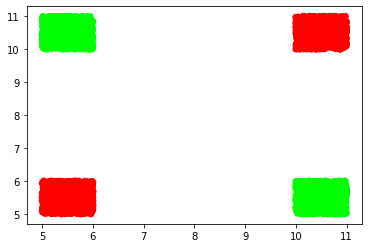

In [141]:
N=1000 # samples per cluster
XY=t.tensor([[5,5],[5,10],[10,5],[10,10]],dtype=t.float32) # 4 cluster centers
Z=t.tensor([0,1,1,0]) # category labels
t.cat([t.randn(2,1)+XY[0,0],t.randn(2,1)+XY[0,1]],1)
xy,z=t.zeros(4*N,2),t.zeros(4*N,dtype=t.int64)
for i in range(4):
    xy[i*N:(i+1)*N,]=t.rand(N,2)+XY[i,]
    z[i*N:(i+1)*N]=Z[i]
xy_np=xy.numpy()
z_np=z.numpy().astype(int)
cmap=np.array([[1,0,0],[0,1,0]])
scatter(xy_np[:,0],xy_np[:,1],color=cmap[z_np]);

#### 2.1 A shallow net with one hidden layer

In [142]:
# Number of free parameters: 2*H+H*2=48
shallow = []
# Fix seed 讓彼此的Linear layer來自同一組initial weight
seed=5
t.manual_seed(seed)
t.cuda.manual_seed(seed)
t.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
np.random.seed(seed)  # Numpy module.
random.seed(seed)  # Python random module.
t.backends.cudnn.benchmark = True
t.backends.cudnn.deterministic = True

H=12 # number of hidden units

model = t.nn.Sequential(
    t.nn.Linear(2, H, bias=False),
    t.nn.BatchNorm1d(H),
    t.nn.ReLU(),
    t.nn.Linear(H, 2, bias=False),
    t.nn.Softmax(dim=1)
)
loss_fn = t.nn.CrossEntropyLoss()
optimizer = t.optim.Adam(model.parameters())

for i in range(500):
    z_pred = model(xy)
    loss = loss_fn(z_pred,z)
    model.zero_grad()
    loss.backward()
    optimizer.step()
    z_pred = model(xy) 
    z_pred = t.max(z_pred,1)[1]
#     print('epoch ',i,':',(z_pred==z).sum().item()/xy.shape[0])
    shallow.append((z_pred==z).sum().item()/xy.shape[0])


#### 2.2 A "deep" net with three hidden layers

In [143]:
# Number of free parameters: 2*H+H*H+H*H+H*2=48
deep_thr = []
# Fix seed 讓彼此的Linear layer來自同一組initial weight
seed=5
t.manual_seed(seed)
t.cuda.manual_seed(seed)
t.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
np.random.seed(seed)  # Numpy module.
random.seed(seed)  # Python random module.
t.backends.cudnn.benchmark = True
t.backends.cudnn.deterministic = True

H=4 # number of hidden units
model = t.nn.Sequential(
    t.nn.Linear(2, H, bias=False),
    t.nn.BatchNorm1d(H),
    t.nn.ReLU(),
    t.nn.Linear(H, H,bias=False),
    t.nn.BatchNorm1d(H),
    t.nn.ReLU(),
    t.nn.Linear(H, H, bias=False),
    t.nn.BatchNorm1d(H),
    t.nn.ReLU(),
    t.nn.Linear(H, 2, bias=False),
    t.nn.Softmax(dim=1)
)
loss_fn = t.nn.CrossEntropyLoss()
optimizer = t.optim.Adam(model.parameters())

for i in range(500):
    z_pred = model(xy)
    loss = loss_fn(z_pred,z)
    model.zero_grad()
    loss.backward()
    optimizer.step()
    z_pred = model(xy) 
    z_pred = t.max(z_pred,1)[1]
#     print('epoch ',i,':',(z_pred==z).sum().item()/xy.shape[0])
    deep_thr.append((z_pred==z).sum().item()/xy.shape[0])

#### 2.3 A "deep" net with four hidden layers

In [144]:
# Number of free parameters: 2*H + H*H + H*H + H*H + H*H + H*2=48
deep_four = []
# Fix seed 讓彼此的Linear layer來自同一組initial weight
seed=5
t.manual_seed(seed)
t.cuda.manual_seed(seed)
t.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
np.random.seed(seed)  # Numpy module.
random.seed(seed)  # Python random module.
t.backends.cudnn.benchmark = True
t.backends.cudnn.deterministic = True

H=3 # number of hidden units
model = t.nn.Sequential(
    t.nn.Linear(2, H, bias=False),
    t.nn.BatchNorm1d(H),
    t.nn.ReLU(),
    t.nn.Linear(H, H,bias=False),
    t.nn.BatchNorm1d(H),
    t.nn.ReLU(),
    t.nn.Linear(H, H, bias=False),
    t.nn.BatchNorm1d(H),
    t.nn.ReLU(),
    t.nn.Linear(H, H, bias=False),
    t.nn.BatchNorm1d(H),
    t.nn.ReLU(),
    t.nn.Linear(H, 2, bias=False),
    t.nn.Softmax(dim=1)
)
loss_fn = t.nn.CrossEntropyLoss()
optimizer = t.optim.Adam(model.parameters())

for i in range(500):
    z_pred = model(xy)
    loss = loss_fn(z_pred,z)
    model.zero_grad()
    loss.backward()
    optimizer.step()
    z_pred = model(xy) 
    z_pred = t.max(z_pred,1)[1]
#     print('epoch ',i,':',(z_pred==z).sum().item()/xy.shape[0])
    deep_four.append((z_pred==z).sum().item()/xy.shape[0])

#### 2.4 A "deep" net with seven hidden layers

In [145]:
# Number of free parameters: 2*H + H*H + H*H + H*H + H*H + H*H + H*H + H*H + H*2=48
deep_seven = []
# Fix seed 讓彼此的Linear layer來自同一組initial weight
seed=5
t.manual_seed(seed)
t.cuda.manual_seed(seed)
t.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
np.random.seed(seed)  # Numpy module.
random.seed(seed)  # Python random module.
t.backends.cudnn.benchmark = True
t.backends.cudnn.deterministic = True

H=2 # number of hidden units
model = t.nn.Sequential(
    t.nn.Linear(2, H, bias=False),
    t.nn.BatchNorm1d(H),
    t.nn.ReLU(),
    t.nn.Linear(H, H,bias=False),
    t.nn.BatchNorm1d(H),
    t.nn.ReLU(),
    t.nn.Linear(H, H, bias=False),
    t.nn.BatchNorm1d(H),
    t.nn.ReLU(),
    t.nn.Linear(H, H, bias=False),
    t.nn.BatchNorm1d(H),
    t.nn.ReLU(),
    t.nn.Linear(H, H, bias=False),
    t.nn.BatchNorm1d(H),
    t.nn.ReLU(),
    t.nn.Linear(H, H, bias=False),
    t.nn.BatchNorm1d(H),
    t.nn.ReLU(),
    t.nn.Linear(H, H, bias=False),
    t.nn.BatchNorm1d(H),
    t.nn.ReLU(),
    t.nn.Linear(H, 2, bias=False),
    t.nn.Softmax(dim=1)
)
loss_fn = t.nn.CrossEntropyLoss()
optimizer = t.optim.Adam(model.parameters())

for i in range(500):
    z_pred = model(xy)
    loss = loss_fn(z_pred,z)
    model.zero_grad()
    loss.backward()
    optimizer.step()
    z_pred = model(xy) 
    z_pred = t.max(z_pred,1)[1]
#     print('epoch ',i,':',(z_pred==z).sum().item()/xy.shape[0])
    deep_seven.append((z_pred==z).sum().item()/xy.shape[0])

### 2.5 Your answers

**Shallow Network:** 僅具有**單層**的hidden layer (i.e Input -> hidden layer -> Output)<br>
**Deep Network:** 具有**兩層或以上**的hidden layer (i.e Input -> hidden layers -> ...-> Output)<br>
問題：在學習XOR問題時，在相同的參數數目底下，使用淺層神經網路，還是深層網路何者比較好，為什麼？<br>
作法：<br>
1. 固定seed，並做**統計t檢定**看兩者(Shallow VS Deep)的Accuracy有無差異，且誰的平均準確率較高。
2. **加深深度**看彼此差異
3. 繪圖


In [148]:
# Parameters
# Shallow Network ,H = 12, 2*H+H*2=48, Hidden Layer Num = 1
# Deep Network_3, H = 4, 2*H + H*H + H*H + H*2=48, Hidden Layer Num = 3
# Deep Network_4, H = 3, 2*H + H*H + H*H + H*H + H*H + H*2=48,Hidden Layer Num = 4
# Deep Network_7, H = 2, 2*H + H*H + H*H + H*H + H*H + H*H + H*H + H*H + H*2=48,Hidden Layer Num = 7
shallow = np.array(shallow)
deep_thr = np.array(deep_thr)
deep_four = np.array(deep_four)
deep_seven = np.array(deep_seven)

def ttest_result(alist, blist, aname, bname):
    from scipy.stats import ttest_ind as ttest
    df = DataFrame({"t-test":[ttest(alist,blist)[0]],
                    "p-value":[ttest(alist,blist)[1]]})
    
    if ttest(alist,blist)[1] >= 0.05:
            report = '''
                    <h1 align='left'><統計檢定報告></h1>
                    <h4 align='left'>虛無假設H0: u({0}) = u({1})</h4>
                    <h4 align='left'>對立假設H1: u({0}) != u({1})</h4>
                    <h4 align='left'>結論:<I>p</I>-value:{2} > 0.05, 接受虛無假設。</h4>
                    <h4 align='left'>表示{0}和{1}之間無差異</h4>
                    '''.format(aname, bname,round(ttest(shallow,deep_thr)[1],5))
    else:
            report = '''
                    <h1 align='left'><統計檢定報告></h1>
                    <h4 align='left'>虛無假設H0: u({0}) = u({1})</h4>
                    <h4 align='left'>對立假設H1: u({0}) != u({1})</h4>
                    <h4 align='left'>結論:<I>p</I>-value:{2} < 0.05, 拒絕虛無假設。</h4>
                    <h4 align='left'>表示{0}和{1}有差異</h4>
                    '''.format(aname, bname,round(ttest(shallow,deep_thr)[1],5))
            if alist.mean() > blist.mean():
                contrast = '''<h4 align='left'>且 {0} 比 {1} 表現好!</h4>
                '''.format(aname, bname)
            else:
                contrast = '''<h4 align='left'>且 {1} 比 {0} 表現好!</h4>
                '''.format(aname, bname)
    display(HTML(report))
    display(HTML(contrast))
    display(HTML(df.to_html()))

### 2.5.1 Shallow Network V.S Deep Network(3 Hidden Layer) 

,t-test,p-value
0,34.370047,1.909044e-171


Text(0, 0.5, 'Accuracy')

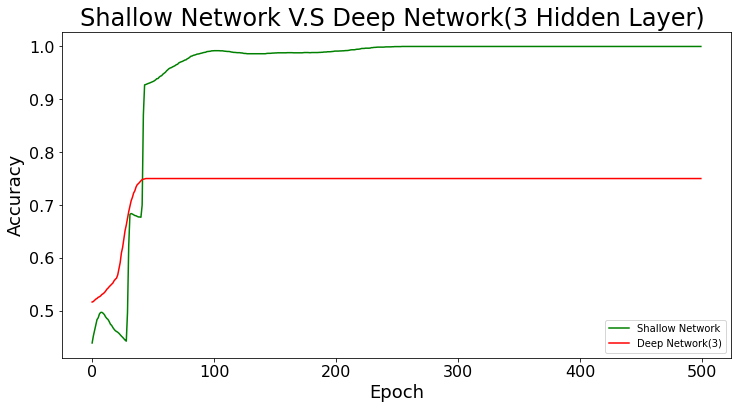

In [149]:
# Statics Result
ttest_result(shallow, deep_thr, 'Shallow Network', 'Deep Network(3)')

# Plot
x = np.arange(500)
fig, ax = subplots(nrows=1, ncols=1, figsize=(12,6), sharey=True)
ax.plot(x, shallow, 'g')
ax.plot(x, deep_thr, 'r', markerfacecolor='None')
legend(['Shallow Network', 'Deep Network(3)']);
ax.set_title('Shallow Network V.S Deep Network(3 Hidden Layer) ', fontsize=24)
ax.tick_params(labelsize=16)
ax.set_xlabel('Epoch', fontsize=18)
ax.set_ylabel('Accuracy', fontsize=18)

### 2.5.2 加深深度

Text(0, 0.5, 'Accuracy')

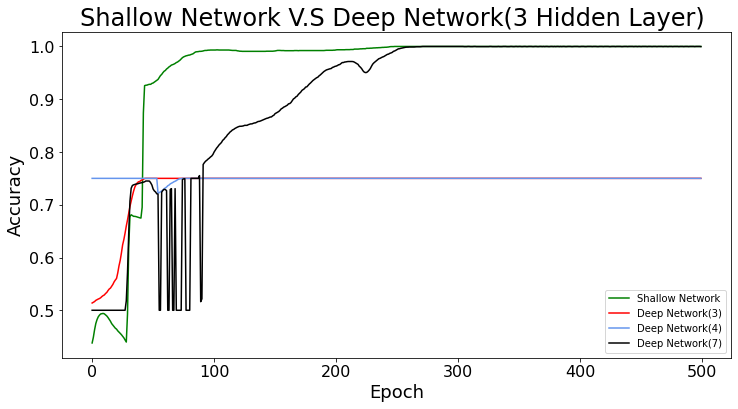

In [132]:
# Plot
x = np.arange(500)
fig, ax = subplots(nrows=1, ncols=1, figsize=(12,6), sharey=True)
ax.plot(x, shallow, 'g')
ax.plot(x, deep_thr, 'r', markerfacecolor='None')
ax.plot(x, deep_four, 'cornflowerblue', markerfacecolor='None')
ax.plot(x, deep_seven, 'black', markerfacecolor='None')
legend(['Shallow Network', 'Deep Network(3)','Deep Network(4)','Deep Network(7)']);
ax.set_title('Shallow Network V.S Deep Network(3 Hidden Layer) ', fontsize=24)
ax.tick_params(labelsize=16)
ax.set_xlabel('Epoch', fontsize=18)
ax.set_ylabel('Accuracy', fontsize=18)

### 結論
#### 現象描述:
1. Shallow Network在XOR Problem上表現比Deep Network好,使用較少的訓練次數可以達到更好的效果。
2. 隨著網路加深以及較多的訓練次數 Deep Network可以慢慢達到較好的學習率。

#### 推測:
1. 每一層網路會學習到不同的特徵，隨著網路加深，越深的網路學習到越複雜的特徵，也許因為XOR是相對簡單的問題，因此Deep Network較不太能體現能習得複雜特徵的優勢。
